MG Systemに対して、Noiseがある/ない場合のlong-term predictionを比べる。

In [120]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

In [121]:
#パラメータ設定

from reservoirpy.datasets import mackey_glass
from reservoirpy.observables import nrmse, rsquare

tau = 17
timesteps = 11500
#warmup:100 timesteps, training: 1500, 
#teseting data(Baysian optimization, short-term prediction) : 900
#teseting data(Baysian optimization, long-term prediction) : 10000


X = mackey_glass(timesteps, tau=tau)
#ここではz-score normalizationを使用。
X = (X - np.mean(X)) / np.std(X) 

In [122]:
def plot_train_test(X_train, y_train, X_test, y_test):
    sample = 500
    test_len = X_test.shape[0]
    fig = plt.figure(figsize=(15, 5))
    plt.plot(np.arange(0, 500), X_train[-sample:], label="Training data")
    plt.plot(np.arange(0, 500), y_train[-sample:], label="Training ground truth")
    plt.plot(np.arange(500, 500+test_len), X_test, label="Testing data")
    plt.plot(np.arange(500, 500+test_len), y_test, label="Testing ground truth")
    plt.legend()
    plt.show()

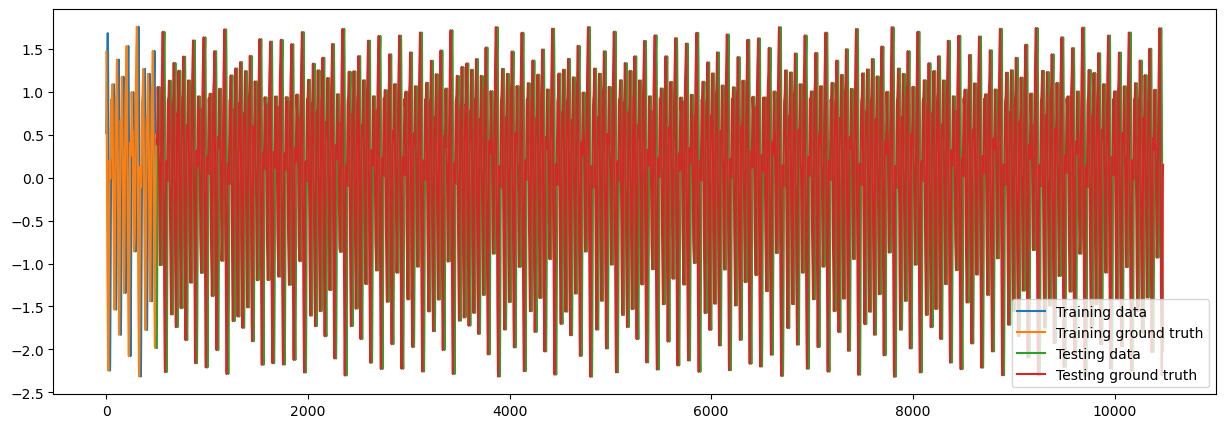

In [123]:
from reservoirpy.datasets import to_forecasting

X, Y = to_forecasting(X, forecast=17)
X_train1, Y_train1 = X[:1500], Y[:1500]
X_test1, Y_test1 = X[1500:], Y[1500:]

plot_train_test(X_train1, Y_train1, X_test1, Y_test1)

In [124]:
units = 500
leak_rate = 0.17113764962939737
spectral_radius = 1.182082887824895
input_scaling = 0.9697295578201843
connectivity = 0.10407566959031667      # - density of reservoir internal matrix
input_connectivity = 0.2  # and of reservoir input matrix
regularization = 5.602814683095597e-09
noise_rc = 3.297333463106559e-05
seed = 1234             # for reproducibility

In [125]:
def reset_esn():
    from reservoirpy.nodes import Reservoir, Ridge

    reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                          lr=leak_rate, rc_connectivity=connectivity,
                          input_connectivity=input_connectivity, seed=seed)
    readout   = Ridge(1, ridge=regularization)

    return reservoir >> readout

In [126]:
from reservoirpy.nodes import Reservoir, Ridge

reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed, 
                      noise_rc=noise_rc, noise_type="normal")

readout   = Ridge(1, ridge=regularization)

esn = reservoir >> readout

In [127]:
Y = esn(X[0])  # initialisation
reservoir.Win is not None, reservoir.W is not None, readout.Wout is not None

(True, True, True)

In [128]:
esn = esn.fit(X_train1, Y_train1, warmup=100)

Running Model-8:   0%|          | 0/1 [00:00<?, ?it/s]

Running Model-8: 1500it [00:00, 13302.69it/s]
Running Model-8: 100%|██████████| 1/1 [00:00<00:00,  8.09it/s]


Fitting node Ridge-8...


In [129]:
def plot_readout(readout):
    Wout = readout.Wout
    bias = readout.bias
    Wout = np.r_[bias, Wout]

    fig = plt.figure(figsize=(15, 5))

    ax = fig.add_subplot(111)
    ax.grid(axis="y")
    ax.set_ylabel("Coefs. of $W_{out}$")
    ax.set_xlabel("reservoir neurons index")
    ax.bar(np.arange(Wout.size), Wout.ravel()[::-1])

    plt.show()

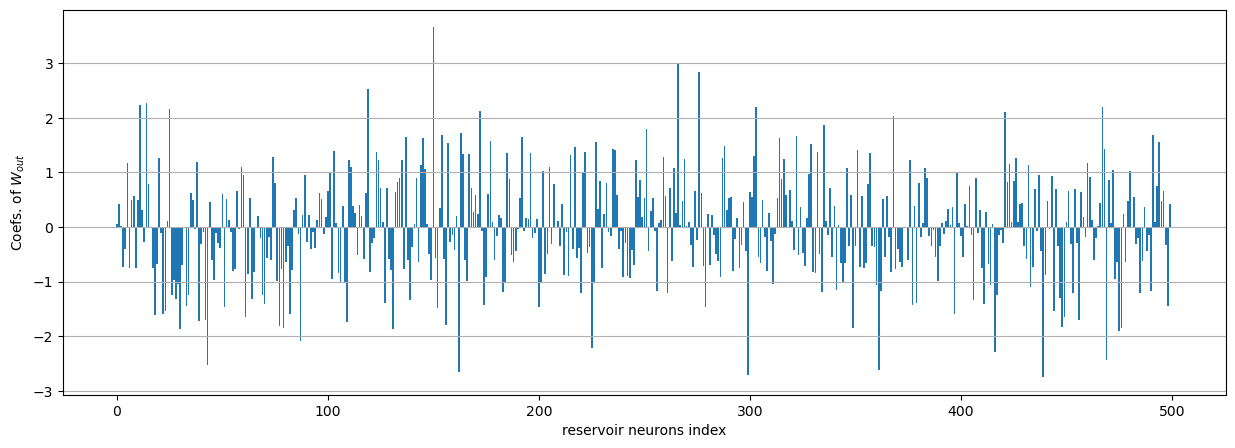

In [130]:
plot_readout(readout)

In [131]:
def plot_results(y_pred, y_test, sample=1500):

    fig = plt.figure(figsize=(15, 7))
    plt.subplot(211)
    plt.plot(np.arange(sample), y_pred[:sample], lw=3, label="ESN prediction")
    plt.plot(np.arange(sample), y_test[:sample], linestyle="--", lw=2, label="True value")
    plt.plot(np.abs(y_test[:sample] - y_pred[:sample]), label="Absolute deviation")

    plt.legend()
    plt.show()

In [132]:
Y_pred1 = esn.run(X_test1)

Running Model-8: 9983it [00:00, 14270.67it/s]         


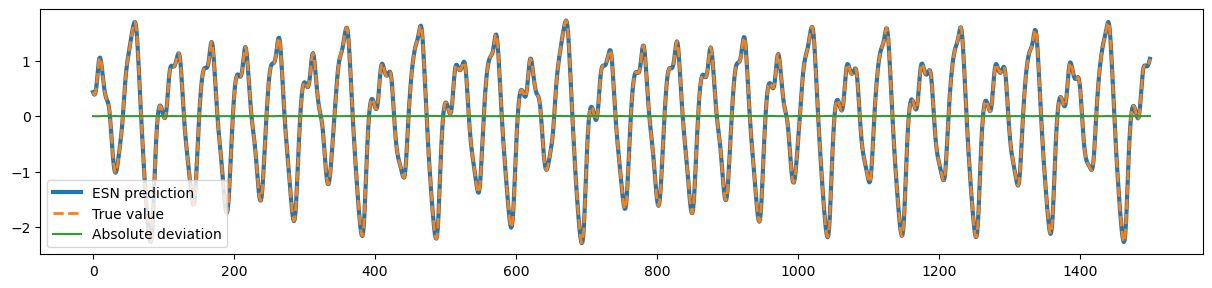

In [133]:
plot_results(Y_pred1, Y_test1)

In [134]:
rsquare(Y_test1, Y_pred1), nrmse(Y_test1, Y_pred1)

(0.9999954488102405, 0.0005233872250012325)

Given 10 last steps, predict the 100 next steps of the timeseries.

$\tau = 17$

$T = 20000\Delta t$

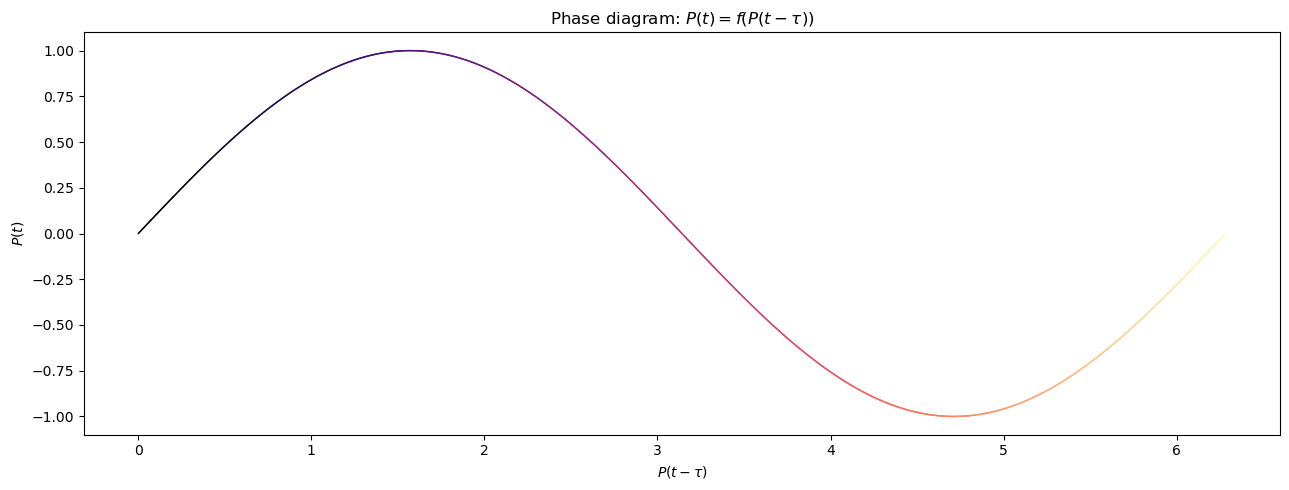

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [135]:
#ChatGPT作。
#範囲の外に出た時について修正が必要。
#升目は絶対数で定義した方が良さそう？

def count_transitions(X, Y_pred, grid_size=0.05):
    # Create grid
    x_bins = np.arange(X.min(), X.max() + grid_size, grid_size)
    y_bins = np.arange(Y_pred.min(), Y_pred.max() + grid_size, grid_size)

    # Label each point with its grid cell
    x_indices = np.digitize(X, x_bins) - 1
    y_indices = np.digitize(Y_pred, y_bins) - 1

    # Create transition matrix
    transition_counts = np.zeros((len(x_bins)-1, len(y_bins)-1))

    # Count transitions
    for i in range(1, len(X)):
        if x_indices[i] != x_indices[i-1] or y_indices[i] != y_indices[i-1]:
            transition_counts[x_indices[i-1], y_indices[i-1]] += 1

    return transition_counts

def plot_mackey_glass2(X, Y_pred, sample, tau):
    N = sample

    plt.figure(figsize=(13, 5))
    ax2 = plt.subplot(1, 1, 1)
    ax2.margins(0.05)
    for i in range(N-1):
        ax2.plot(X[i:i+2], Y_pred[i:i+2], color=plt.cm.magma(255*i//N), lw=1.0)

    plt.title(f"Phase diagram: $P(t) = f(P(t-\\tau))$")
    plt.xlabel("$P(t-\\tau)$")
    plt.ylabel("$P(t)$")

    plt.tight_layout()
    plt.show()

    # Count transitions and return
    transitions = count_transitions(X, Y_pred)
    return transitions

# Test the function
X = np.linspace(0, 2*np.pi, 1000)
Y_pred = np.sin(X)
transitions = plot_mackey_glass2(X, Y_pred, 1000, 1)
print(transitions)
